# Example: Decaying Turbulence

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np

## Setup
The dimension of DecayingTurbulence vortex is defined by the stencil. Here the flow is two dimensional due to D2Q9. Special Inputs & standard values that can be set in the flow constructor are ...
* the wavenumber_energy-peak k0 (= 20 as default) 
* the initial_energy (= 0.5 as default)

In [2]:
lattice = lt.Lattice(lt.D2Q9, device = "cpu")
flow = lt.DecayingTurbulence(resolution=256, reynolds_number=10000, mach_number=0.05, lattice=lattice)
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)
energyspectrum = lt.EnergySpectrum(lattice, flow)
reporter = lt.ObservableReporter(energyspectrum, interval=500, out=None)
simulation.reporters.append(reporter)

steps     time     EnergySpectrum


/home/ben/anaconda3/envs/lettuce/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Initialized flow
The initialized velocity is randomly generated and depends on the wavenumber peak k0, the initial energy, which are given in the flow constructor, and a given energy spectrum.

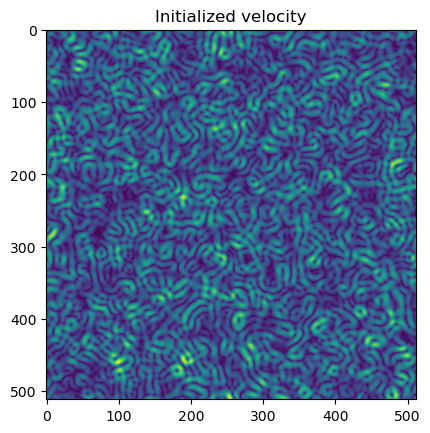

In [3]:
u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f)).numpy()
u_norm = np.linalg.norm(u,axis=0)
plt.imshow(u_norm)
plt.title('Initialized velocity')
plt.show()

### Energy spectrum
The energy spectrum, which is forced in the beginning is given with:

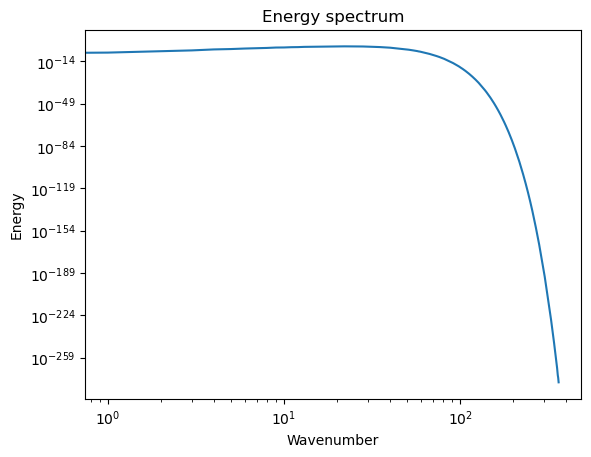

In [4]:
spectrum = flow.energy_spectrum
plt.loglog(spectrum[1],spectrum[0])
plt.title('Energy spectrum')
plt.xlabel('Wavenumber')
plt.ylabel('Energy')
plt.show()

## Run simulation
Before the simulation is executed, the pressure field is obtained by solving the pressure poisson equation. In addition, f_neq is initialized to obtain stress tensor at the start of the simulation.

In [5]:
simulation.initialize_pressure()
simulation.initialize_f_neq()
mlups = simulation.step(num_steps=15000)
print("Performance in MLUPS:", mlups)

Performance in MLUPS: 16.72336831131761


### Velocity
* Velocity field after the simulation

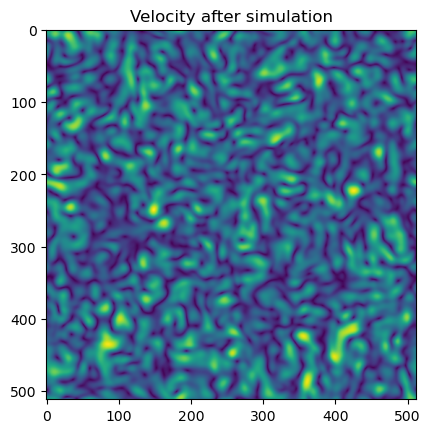

In [6]:
u = flow.units.convert_velocity_to_pu(lattice.u(simulation.f)).numpy()
u_norm = np.linalg.norm(u,axis=0)
plt.imshow(u_norm)
plt.title('Velocity after simulation')
plt.show()

### Vorticity
* Vorticity field after the simulation

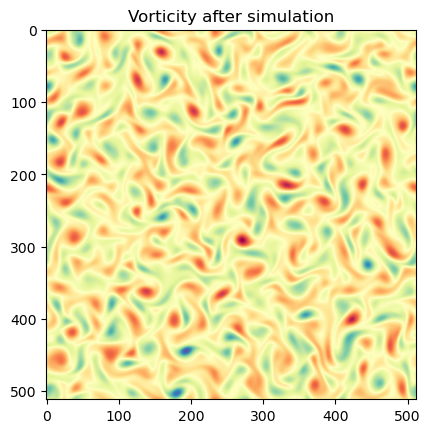

In [7]:
dx = flow.units.convert_length_to_pu(1.0)
grad_u0 = np.gradient(u[0], dx)
grad_u1 = np.gradient(u[1], dx)
vorticity = (grad_u1[0] - grad_u0[1])
plt.imshow(vorticity, cmap='Spectral')
plt.title('Vorticity after simulation')
plt.show()

### Energy spectrum after simulation

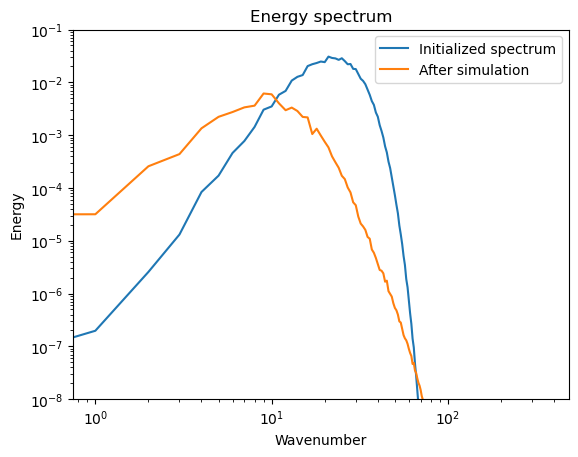

In [8]:
spectrum_final = simulation.reporters[0].out[-1]
plt.loglog(spectrum[1],spectrum[0],label='Initialized spectrum')
plt.loglog(spectrum[1],spectrum_final[2:],label='After simulation')
plt.title('Energy spectrum')
plt.xlabel('Wavenumber')
plt.ylabel('Energy')
plt.ylim(top=1e-1, bottom=1e-8)
plt.legend()
plt.show()